# Lab 2: Introduction to Curve Fitting in ROOT

![alt-text](https://root.cern.ch/root/htmldoc/guides/users-guide/pictures/03000070.png "")


## Table of Contents
1. **[Fit Example](#fit-example)**
2. **[Creating a Fitting Function](#creating-fitting-function)**  
   2.1. [The TF1 Class](#tf1-class)  
   2.2. [Predefined Functions](#predefined-functions)  
   2.3. [Exercise](#create-fit-func-exercise)  
3. **[The Fit Method](#fit-method)**  
   3.1. [Fitting a Histogram](#fitting-histogram)  
   3.2. [Fitting Options](#fit-options)  
   3.3. [Exercise](#fit-exercise)  
4. **[RooFit](#roofit)**  
   4.1. [RooRealVar](#roorealvar)  
   4.2. [RooDataset](#roodataset)  
   4.3. [Fitting with RooAbsPdf](#fitting-rooabspdf)  
   4.4. [Exercise](#roofit-exercise)  
5. **[$\chi^2$ Pull Distributions](#pulls)**  
   5.1. [Exercise](#pulls-practice)

## 1. Fit Example <a name="fit-example" />
Below is an example of fitting a function to a histogram. We will break down this code and see the different ways you can fit a function to data and discuss why we want to do this.

 FCN=62.0215 FROM MIGRAD    STATUS=CONVERGED      31 CALLS          32 TOTAL
                     EDM=3.26367e-22    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -7.56534e+01   2.43473e+00   5.48230e-03   1.29607e-11
   2  p1           2.28477e+02   3.00594e+00   6.76849e-03   2.62445e-12
 FCN=78.849 FROM MIGRAD    STATUS=CONVERGED      61 CALLS          62 TOTAL
                     EDM=2.87322e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.39420e+02   2.98901e+00   1.04878e-02   3.07903e-04
   2  Mean         9.56366e-03   1.01191e-02   4.41268e-05  -1.04706e-02
   3  Sigma        9.94429e-01   7.57122e-03   8.92460e-06   2.65667e-01


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


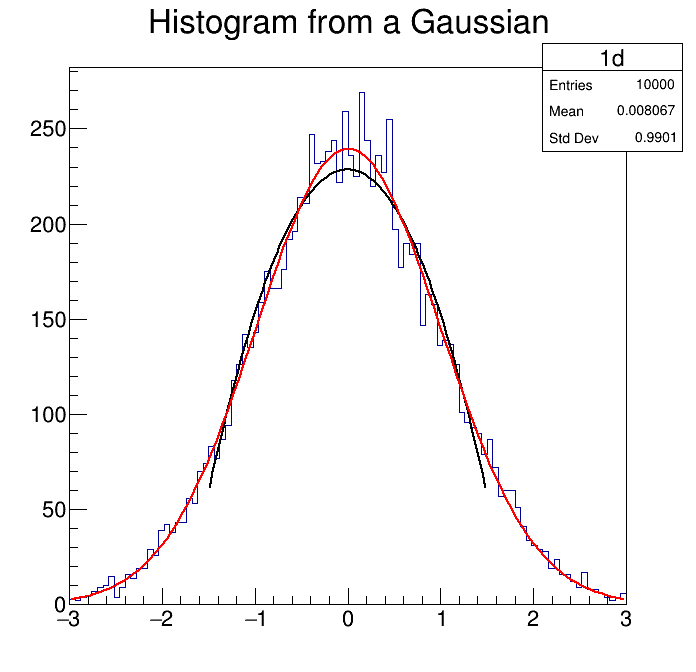

Info in <TCanvas::Print>: png file fitted_hist.png has been created


In [1]:
// 1D Histogram
TH1F * oneDimHist = new TH1F("1d", "Histogram from a Gaussian", 100, -3, 3);
oneDimHist->FillRandom("gaus", 10000);

TF1 * fittingFunction = new TF1("name", "[0]*x^2 + [1]", -1.5, 1.5);
fittingFunction->SetParameter(0, 20);
fittingFunction->SetParameter(1, 200);
fittingFunction->SetLineColor(1);
oneDimHist->Fit("name", "R");
oneDimHist->Fit("gaus", "+");

TCanvas * canvas = new TCanvas("canvas_name", "canvas_name", 700, 700);
oneDimHist->Draw();
canvas->SaveAs("fitted_hist.png");
canvas->Draw();

## 2. Creating a Fitting Function <a name="creating-fitting-function" />
The class that is used to represent a function is the `TF1` class. The `TF1` class is used to represent any function. You can specify parameters than are allowed to change their value in the definition of the function so that we can change these parameters in an attempt to fit this function as close to the histogram as possible. 

There are two classes of functions available to use: user-defined functions and predefined functions. We will first cover user-defined functions as they can do everything a predefined function can and then will later list some of the predefined functions. You need to be careful when using a predefined function to ensure that the function will be able to fit the data correctly.


### 2.1 The TF1 Class <a name="tf1-class" />
To create a user-defined fitting function, you will type `fitting_function = ROOT.TF1("name", "expression", xmin, xmax)`, where `name` is the name of the funciton, `expression` is the mathematical expression of the function, `xmin` is the minimum x value the function covers, and `xmax` is the maximum x value the function covers. An example of this is:
```c++
TF1 * fittingFunction = new TF1("quadratic", "[0]*x^2 + [1]", -1.5, 1.5);
```
The mathematical expression for this function is equivalent to:
$$
f(x) = ax^2 + c
$$
where $a$ and $c$ can be any real value. `[x]` in the expression denotes a variable that can be changed to any value to help fit the function where x is the ID of the parameter. This function is also only defined on the inteval $[-1.5, 1.5]$.

Sometimes when you try fitting your function you will realize that you are getting a very bad fit to the data even though you know the data kind of follows this function in this range. One possible reason for this is that the adjustable parameters are starting at initial values that make it hard for the program to adjust it to the correct values to accurately fit the data. We can help the program in fitting these functions by guessing what the initial values should be and by setting ranges on what values the variable can take on. To set the initial values of the parameters we can use the `SetParameter` or the `SetParameters` methods.

```c++
fittingFunction->SetParameter(0, 20);
fittingFunction->SetParameter(1, 200);
```
or
```c++
fittingFunction->SetParameters(20, 200);
```
In both cases we are setting the variable `[0]` to 20 and the variable `[1]` to 200. To set limits we will use the method `SetParLimits`.

```c++
fittingFunction->SetParLimits(0, 0, 100);
fittingFunction->SetParLimits(1, 0, 1000);
```
__NOTE__: Be careful when setting limits on parameters. Only set limits when you know the variable absolutely should not be outside of these ranges. Otherwise, you could be obtaining a sub-optimal fit. One way to see this happening is if the fitter is choosing one of your limits as the best value for the parameter, but that does not have to be the case for every sub-optimal fit.

### 2.2 Predefined Functions <a name="predefined-functions" />
There are a lot of functions that are used over and over to fit histograms, so ROOT has gone out of the way and defined some of these functions for you. I will list the `"name"` of the popular ones here but you may be able to find more if you search through ROOT's documentation.

* `"gaus"`: A Gaussian function with 3 parameters: $A$, $\mu$, and $\sigma$.
$$
f(x) = Ae^{-\left(\frac{x-\mu}{\sigma}\right)^2}
$$
* `"expo"`: An exponential function with 2 parameters: $a$ and $b$.
$$
f(x) = e^{a + bx}
$$
* `"pol N"`: A polynomial of degree N, where N is between 0 and 9.
$$
f(x) = a_0 + a_1x + a_2x^2 + ... + a_Nx^N
$$
* `"chebyshev N"`: A Chebyshev polynomial of degree N, where N is between 0 and 9.
$$
f(x) = a_0 + a_1x + a_2\left(2x^2 - 1\right) + ... + a_NT_N(x)
$$
* `"gausn"`: The normalized Gaussian function with 3 parameters: $A$, $\mu$, and $\sigma$.
$$
f(x) = \frac{A}{\sigma \sqrt{2\pi}}e^{-\left(\frac{x-\mu}{\sigma}\right)^2}
$$

### 2.3 Exercise <a name = "create-fit-func-exercise">
Create a fitting function the matches the function:
$$
f(x) = \frac{2}{R^2\pi}\sqrt{R^2 - x^2}
$$
where R is your variable that is allowed to change its value, on the interval $[-5, 5]$.

In [ ]:
// Code goes here

## 3. The Fit Method <a name = "fit-method">
Now that we know how to create functions that can be fitted to histograms, we need to actually fit these functions to our histograms. This is very easy to do and can be done with the `Fit` method belonging to the `TH1` class.

### 3.1 Fitting a Histogram <a name = "fitting-histogram">
First we need to create a histogram. We will just create a histogram and fill it from a Gaussian.
```c++
TF1F * oneDimHist = new TH1F("1d", "Histogram from a Gaussian", 100, -3, 3);
oneDimHist->FillRandom("gaus", 10000);
```
Now we simply pass the name of the fitting function we want to use through `Fit()` and the function will be fitted to the histogram.
```c++
oneDimHist->Fit("quadratic");
```
This is fitting the histogram to our previously user-defined fitting function in [2.1. The TF1 Class](#tf1-class). If we wanted to use a predefined function we could simply do this as so:
```c++
oneDimHist->Fit("gaus");
```
    
Fitting is really that easy!


### 3.2 Fitting Options <a name = "fit-options">
There are plenty of options that can be used in performing your fit so as to ensure that you get the best fit or to simply change what is happening to the fit. Here is a list of some of the more predominant options, but a full list can be found [here](#https://root.cern.ch/doc/master/classTH1.html#a7e7d34c91d5ebab4fc9bba3ca47dabdd).
    
* `"L"`: Use Loglikelihood method (default is chisquare method). To be used when the histogram represents counts
* `"Q"`: Quiet mode (minimum printing)
* `"V"`: Verbose mode (default is between Q and V)
* `"E"`: Perform better Errors estimation using Minos technique
* `"R"`: Use the Range specified in the function range
* `"0"`: Do not plot the result of the fit. By default the fitted function is drawn unless the option "N" is specified.
* `"+"`: Add this new fitted function to the list of fitted functions (by default, any previous function is deleted)
* `"F"`: If fitting a polN, switch to minuit fitter

### 3.3 Exercise <a name = "fit-exercise">

Fit a falling and rising exponential on the intervals $[0, 3]$ and $[-3, 0]$, respectively, for the below histogram. Draw the resultant histogram and fits and ensure both fits are on the same plot.

In [ ]:
TH1F * hist = new TH1F("1d", "Histogram from a Gaussian", 100, -3, 3);
hist.FillRandom("gaus", 10000)

// Fitting goes here
falling_expo = 
rising_expo = 

## 4 RooFit <a name = "roofit">

Now we will discuss a more abstract, but more user-friendly, method to fitting which can readily be used to find mathematical moodels from a distribution in a `TTree`. The library is called RooFit and is already a part of ROOT so there is no further installation required. Simply call `from ROOT import RooFit` and you can access the library's functions. We will now delve into detail how to utilize RooFit's object-oriented approach for fitting, but quick references can be found [here](#https://root.cern.ch/roofit-20-minutes) and [here](#https://root.cern.ch/download/doc/roofit_quickstart_3.00.pdf).

### 4.1 RooRealVar <a name = "roorealvar">
`RooRealVar`'s are objects which act as the variable of the function you build. A quick example of defining a `RooRealVar`:
    

In [1]:
RooRealVar * x = new RooRealVar("top_pt", "top transverse momentum [MeV/c]", 0, 800);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Here we have defined the $x$ to our $f(x)$. As you can see, we have defined a name for this variable "top_pt" where "top" is the top quark, usually written as $t$, and "pt" is the transverse momentum of the particle, it's units "MeV/c", and the range over which we want to define our model.  Typically it will not be useful to fit over $-\infty$ to $\infty$. No distribution that you are trying to fit will have entries over this entire range, and thus this will make the fit algorithm work harder. It is best to simply define your range as the range that best covers your data. Normally, you can view whatever distribution you plan on fitting in a `TBrowser` to get a good idea for what range you should pick. In this example we will be performing a fit of the *top_pt* from *ee_ttbarsignalplustau.root*.

### 4.2 RooDataset <a name = "roodataset">

Before deciding on a model, lets get an idea of what the top_pt looks like. As stated earlier, you could do this in a `TBrowser`, but we will plot the distribution from a `RooDatase` for showcasing. First we grab the `TTree` object from the ROOT file.

In [2]:
TFile * root_file = TFile::Open("../../Datasets/TTbar/ee_ttbarsignalplustau.root");
TTree * my_tree = (TTree *) root_file->Get("ttBar_treeVariables_step8;4");
printf("TTree imported!");


RooDataSet * dataset = new RooDataSet("data", "top_pt data", my_tree, RooArgSet(*x));
printf("RooDataSet created from TTree of top_pt");


TTree imported![#1] INFO:Eval -- RooAbsReal::attachToTree(top_pt) TTree Float_t branch top_pt will be converted to double precision
[#1] INFO:Eval -- RooTreeDataStore::loadValues(data) Ignored 108 out of range events
RooDataSet created from TTree of top_pt

The defined name of your x, for us "top_pt", tells `RooDataSet` which branch to read from the `TTree` into the dataset. Since we defined a range of $(0,800)$, RooFit won't import any events beyond this range. Here it ignored 108 events out of the range. But compared to 155,021 total events, this is negligible. Let's see what this dataset looks like.

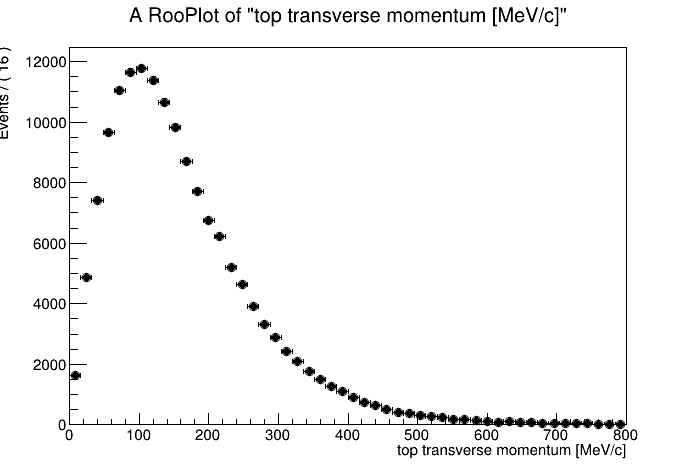

Info in <TCanvas::Print>: png file top_pt_data.png has been created


In [3]:
RooPlot * xframe = x->frame();
dataset->plotOn(xframe, RooFit::Binning(50));
TCanvas * canvas2 = new TCanvas();
xframe->Draw();
canvas2->SaveAs("top_pt_data.png");
canvas2->Draw();


In RooFit, it is quite easy to create and save a plot. `x.frame()` and `xframe.Draw()` take care of preparing the canvas for us from what we defined earlier. You can even change the binning to what you like when you plot the dataset to the frame. Try not to set the binning too coarse as you may lose some key features visually of the data. If you set the binning to 5, you may be convinced this is an exponential. Conversely if you set the binning to high, it becomes difficult and cluttered to read. Try it for yourself.

### 4.3 Fitting with RooAbsPdf <a name = "fitting-rooabspdf">
Now we need to choose a probability density function (pdf) to model our dataset from. This is entirely guess work, but you should have a good idea where to start by looking at the initial distribution. We just need to give RooFit a reasonable guess that it can optimize for us. We could try modeling the dataset off a combiniation of a gaussian and a decaying exponential. However, we will use a more complicated function called the [Crystal Ball function](#https://en.wikipedia.org/wiki/Crystal_Ball_function). The Crystal Ball is a gaussian shape with a decaying tail and is commonly used in High Energy Physics (HEP). 

In [4]:
// Shared mean of Crystal Ball functions
RooRealVar * mean = new RooRealVar("mean", "mean", 100, 0, 200);

// First Crystal ball fnction
RooRealVar * sigma_1 = new RooRealVar("sigma_1", "sigma_1", 100, 0, 1000);
RooRealVar * alpha_1 = new RooRealVar("alpha_1", "alpha_1", 1, 0, 100);
RooRealVar * n_1 = new RooRealVar("n_1", "n_1", 1, 0, 1000);
RooCBShape * cb_1 = new RooCBShape("CB1", "CB1", *x, *mean, *sigma_1, *alpha_1, *n_1);

// Second Crystal ball function
RooRealVar * sigma_2 = new RooRealVar("sigma_2", "sigma_2", 49, 0, 1000);
RooRealVar * alpha_2 = new RooRealVar("alpha_2", "alpha_2", -1.0, -100.0, 0.0);
RooRealVar * n_2 = new RooRealVar("n_2", "n_2", 1, 0, 10000);
RooCBShape * cb_2 = new RooCBShape("CB2", "CB2", *x, *mean, *sigma_2, *alpha_2, *n_2);

// Add PDFs
RooRealVar * rel_frac = new RooRealVar("rel_frac", "Relative Fraction", 0.2, 0.0, 1.0);
RooAddPdf * model = new RooAddPdf("model", "model", RooArgList(*cb_1, *cb_2), RooArgList(*rel_frac));

This model is obviously complicated and has many parameters. The more complicated your model is, the more trouble RooFit will have getting a good fit. The initial values have been specially set to give us a good fit, but when you start from scratch it can take a while to figure out what works. Lets take a deeper look at how we create this model.  

For every parameter of the model, we have to create a `RooRealVar`, give it an initial value, and give it a range. Once you have created a `RooRealVar` for each parameter, you feed them into the constructor of the`RooAbsPdf`. Each `RooAbsPdf` will have a different number of parameters. For example, a `RooExponential` only has 1 parameter while `RooCBShape` has 4.  

Note that each Crystal Ball function shares the same mean. We use two Crystal Balls since the alpha parameter controls the direction of the trailing tail: left if its positive and right if its negative. We can see from our plot the tail trails to the right, but we will include both variants for generality. RooFit will decide for itself which Crystal Ball has more weight. Next, we want to add both functions together. However, we first must define a relative fraction variable since `RooAddPdf` is performing: $$f_{model}(x) = A*f_{CB1}(x)+(1-A)*f_{CB2}(x)$$ `rel_frac` is our A value here, which ranges from 0 to 1. Now let's fit our model to the $t_{pt}$.

In [5]:
// Fit PDF to data
model->fitTo(*dataset, RooFit::PrintLevel(-1), RooFit::PrintEvalErrors(-1));
printf("Fit complete!");

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (CB1,CB2)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: deactivating const optimization
Fit complete!

The fit can take a while to complete: expect more complicated models to take longer. `fitTo()` only requires one argument, a `RooDataSet`, but additional options can be given. The first two reduce the ammount `fitTo()` prints into the terminal. This information is important, but for the sake of example we don't need it. Pay attention to what `fitTo()` prints when performing fits. `RooFit.Save()` makes `fitTo()` return a `RooFitResults` object which we can print to see the final values of the parameters. Let's take a visual look at the resulting fit.

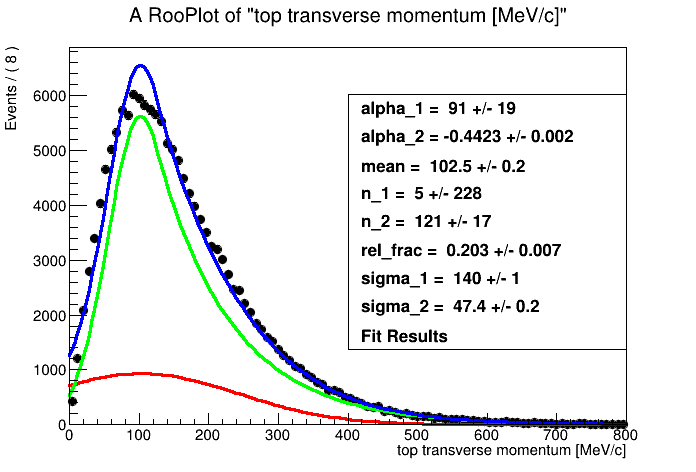

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (CB1)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (CB2)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


Info in <TCanvas::Print>: pdf file top_pt_CBfit.pdf has been created


In [6]:
// Plot data_set, model, and components of the model
RooPlot * xframe2 = x->frame();
dataset->plotOn(xframe2);
model->plotOn(xframe2);
model->plotOn(xframe2, RooFit::Components("CB1"), RooFit::LineColor(kRed));
model->plotOn(xframe2, RooFit::Components("CB2"), RooFit::LineColor(kGreen));
model->plotOn(xframe2);
model->paramOn(xframe2, RooFit::Label("Fit Results"), RooFit::Format("NEU", RooFit::AutoPrecision(1)), RooFit::Layout(0.5,0.9,0.8));
TCanvas * canvas3 = new TCanvas();
xframe2->Draw(); 
canvas3->SaveAs("top_pt_CBfit.pdf");
canvas3->Draw();


The blue line represents our model, while the green and red line are the individual Crystal Balls. We can see this model fits quite well.

### 4.4 Exercise  <a name="fit-exercise2" />
Instead of using two Crystal Balls, fit a gaussian and an exponential to the top_pt and tbar_pt from the ROOT file. Compare the two models. Which one fits better the distribution better? 
    
After those fits, attempt a fit of the all_mass distribution. Find a model which works well.

In [7]:
// Define Observable


// Define gaussian parameters and create RooGaussian


// Define exponential parameter and create RooExponential


// Define relative fraction and combine the RooGaussian and RooExponential to a model


// Import TTree from ROOT file and create RooDataSet


// Fit model to RooDataSet


// Plot the RooDataSet, the model, and it's components.



Tips:
* When calling `fitTo()` do not supress the print. It will give you an idea of what values the parameters are settling on. 
* If a parameter is set to it's limit, you need to expand the range the parameter can be set to. If a parameter has a high error, consider changing the initial values closer to what you think will work.

## 5. $\chi^2$ Pull Distributions <a name="pulls" />

Now that we have a model, it is important that we get an idea of how accurate this model is. Since RooFit does not use a linear regression, we will not calculate a coefficient of determination. Instead we will 

In [8]:
// Create Canvas and prepare 2 pads
TCanvas * canvas4 = new TCanvas("chi2residpull", "chi2residpull", 900, 600);
double mainFrameHeight = 0.75;
double pullFrameHeight = 1 - mainFrameHeight;
double mainPullRatio = mainFrameHeight / pullFrameHeight;

// Define range of pulls to display
double numSigmaPullRange = 3.99;

In [9]:
// Prepare pad for dataset and model
TPad * pad1 = new TPad("pad1", "The main pad", 0.0, pullFrameHeight, 1.0, 1.0);
pad1->SetBottomMargin(0);

// Edit pad for dataset and model
pad1->cd();
xframe2->SetMinimum(0.1);
xframe2->GetXaxis()->SetLabelSize(0.0);

// Need binning on pad1 and pad2 to match
int bins = xframe2->GetNbinsX();
double rangeMinX = xframe2->GetXaxis()->GetXmin();
double rangeMaxX = xframe2->GetXaxis()->GetXmax();
double stepSize = (rangeMaxX - rangeMinX) / (2 * bins);

// Draw frame with dataset and model to pad1
xframe2->Draw();

In [10]:
// Prepare and Draw pull pad
TPad * pad2 = new TPad("pad2", "The pull pad", 0.0, 0.0, 1.0, pullFrameHeight);
pad2->SetTopMargin(0);
pad2->SetBottomMargin(0.4); // We want to leave space under pad2 in the canvas

// Set up pulls plot
RooHist * hpull = xframe2->pullHist();
for(int i = 0; i < bins; ++i) {
    hpull->SetPointError(i, stepSize, stepSize, 0, 0);
}
hpull->SetMarkerSize(hpull->GetMarkerSize() * 0.5);

In [11]:
// Create a frame and add hpull to it
RooPlot * framePulls = x->frame();
framePulls->addPlotable(hpull, "P");

// Format pull frame
framePulls->SetMinimum(-numSigmaPullRange);
framePulls->SetMaximum(numSigmaPullRange);
framePulls->GetXaxis()->SetTitleSize(0.06 * mainPullRatio);
framePulls->GetXaxis()->SetLabelSize(0.06 * mainPullRatio);
framePulls->GetXaxis()->SetTickSize(0.05);

framePulls->GetYaxis()->SetTitle("P-?ll");
framePulls->GetYaxis()->SetTitleSize(0.072 * mainPullRatio);
framePulls->GetYaxis()->SetTitleOffset(0.95 / mainPullRatio);
framePulls->GetYaxis()->SetLabelSize(0.06 * mainPullRatio);         

// Add sigma lines
TLine * zeroLine = new TLine(rangeMinX, 0.0, rangeMaxX, 0.0);

TLine * threeSigmaLine = new TLine(rangeMinX, 3.0, rangeMaxX, 3.0);
threeSigmaLine->SetLineStyle(2); // makes line dashed
threeSigmaLine->SetLineColor(922); // makes color grey

TLine * minusThreeSigmaLine = new TLine(rangeMinX, -3.0, rangeMaxX, -3.0);
minusThreeSigmaLine->SetLineStyle(2); // makes line dashed
minusThreeSigmaLine->SetLineColor(922); // makes color grey

In [12]:
// Draw frame with pulls to pad2
pad2->cd();
framePulls->Draw();
zeroLine->Draw("same");
threeSigmaLine->Draw("same");
minusThreeSigmaLine->Draw("same");

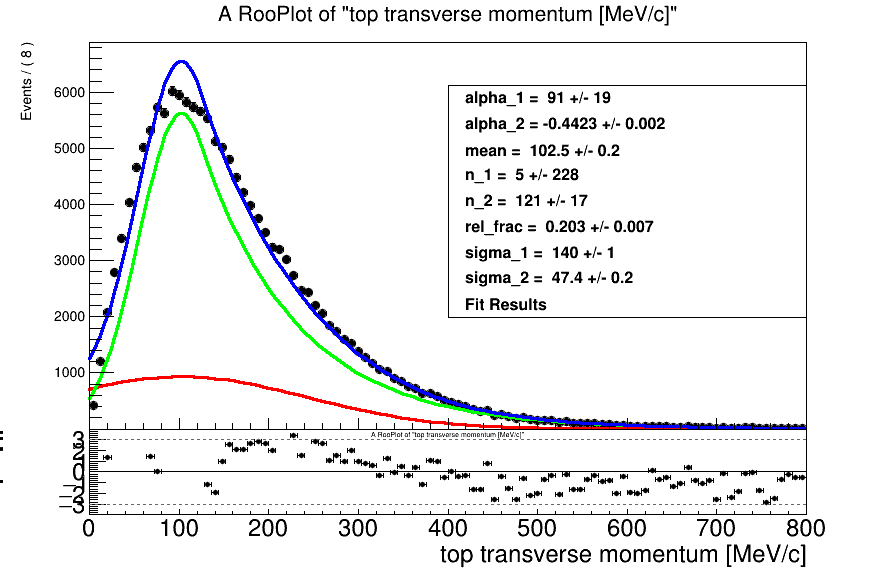

Info in <TCanvas::Print>: pdf file pulls_residuals.pdf has been created


In [13]:
// Draw pad1 and pad2 to the canvas and save it.
canvas4->cd();
pad1->Draw();
pad2->Draw();
canvas4->SaveAs("pulls_residuals.pdf");
canvas4->Draw();

Now we can quantifiably asses the accuracy of our current model. Our model works relatively well for large pt > 300, but for low pt the fit is more than 3 sigma off. This is a lot of work and is tedious to format everytime. For future use, it is best to create a function that takes the frame with your fit and returns the canvas above. This way you don't have to do all this formating everytime you need to make a plot of your fit.

### 5.1 Exercise <a name="pulls-practice" />
Get the pulls from your gaussian and exponential fits of the top_pt, tbar_pt, and all_mass. How good are your fits? Take a closer look at which model is better: the Crystal Balls or a gaussian and a exponential?